[*********************100%***********************]  503 of 503 completed


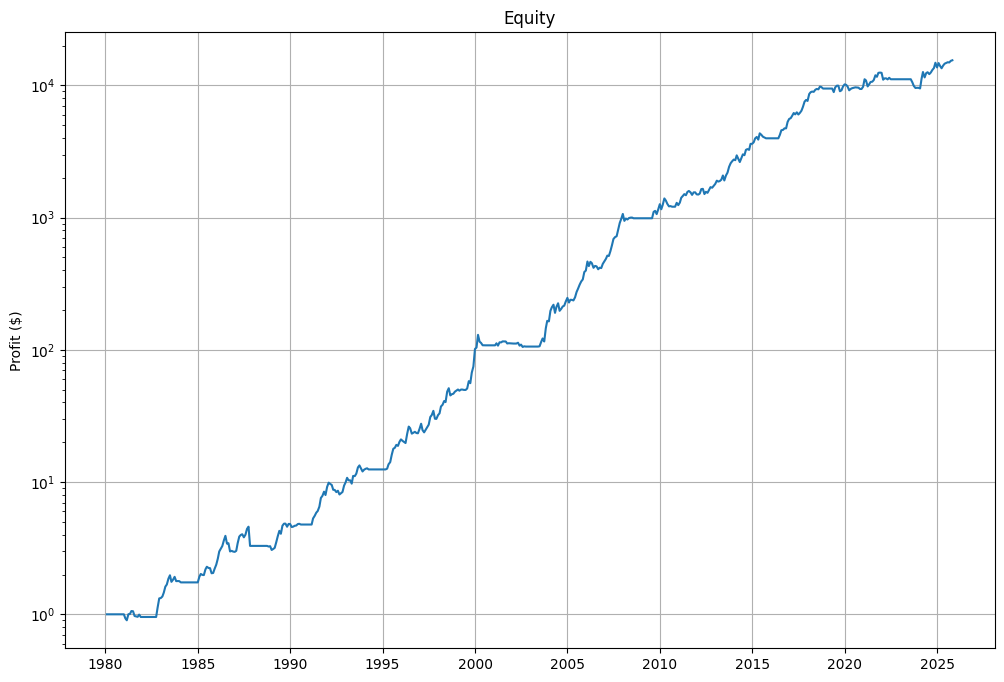

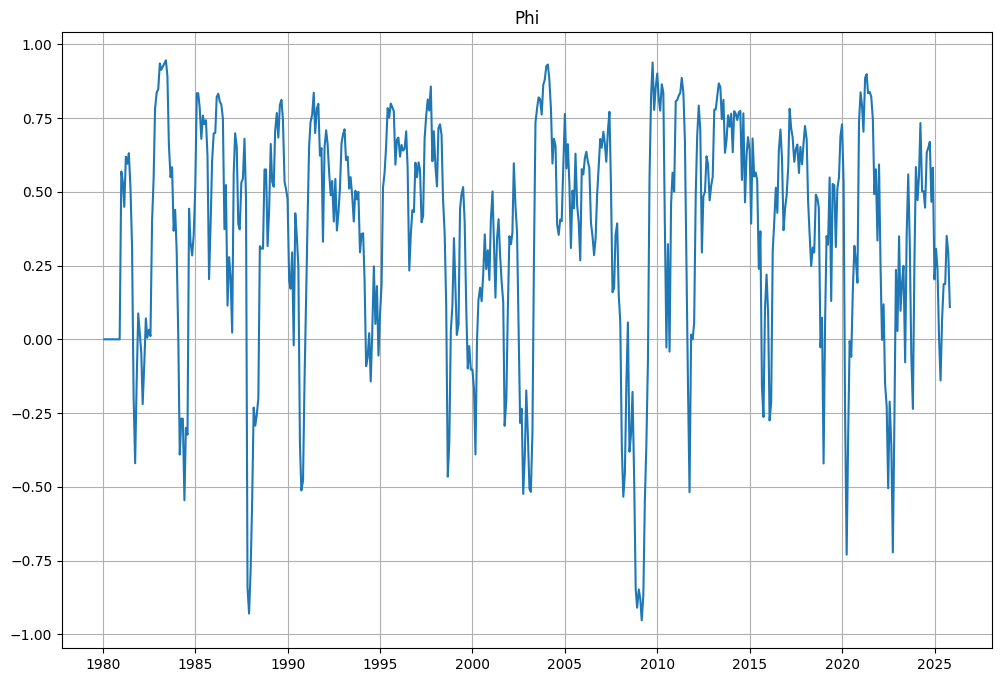


31/01/2025 14758.38 [['PLTR/82.49'], ['VST/167.35'], ['HWM/126.32'], ['RCL/264.12'], ['KKR/166.38'], ['APP/369.59']]
28/02/2025 14052.88 [['PLTR/84.92'], ['HWM/136.42'], ['RCL/243.81'], ['APP/325.74']]
31/03/2025 13483.35 [['PLTR/84.4'], ['HWM/129.56']]
30/04/2025 14119.13 [['PLTR/118.44'], ['HWM/138.4']]
30/05/2025 14598.26 [['PLTR/131.78'], ['HWM/169.78']]
30/06/2025 14788.1 [['PLTR/136.32'], ['HWM/186.01']]
31/07/2025 14976.55 [['PLTR/158.35'], ['HWM/179.65']]
29/08/2025 14914.76 [['PLTR/156.71'], ['HWM/174.1']]
30/09/2025 15349.04 [['PLTR/182.42'], ['HWM/196.23']]
30/10/2025 15494.44 [['PLTR/194.55'], ['HWM/201.77']]

Mean: 0.23 Stdev 0.21 Sharpe 1.13


In [1]:
import urllib, yfinance as yf, pandas as pd, datetime
import numpy as np, matplotlib.pyplot as plt
from bs4 import BeautifulSoup

size = 10 #@param {type:"integer"}
eps= 1.0e-10


def GetSP500():
  url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  headers = {'User-Agent': 'Mozilla/5.0'}
  with urllib.request.urlopen(urllib.request.Request(url, headers=headers)) as response:
    res = response.read()
  table = BeautifulSoup(res, "html.parser").find_all("table", { "class" : "wikitable sortable mw-collapsible sticky-header" })
  ll=[]
  for row in table[0].find_all("tr"):
    cells = row.find_all("td")
    if len(cells)>=3: ll.append([cells[0].text.replace(".","-").replace("_","-").replace(" ","").replace("\n",""), cells[1].text, cells[2].text, cells[3].text])
  return ll


def GetHistos():
    codes = GetSP500()
    data = yf.download(tickers = [l[0] for l in codes], interval = '1d', period = 'max', group_by = 'ticker', threads = True, auto_adjust=True)
    return data.xs('Close', axis=1, level=1)


def Trace(df, cumul, title, ylabel, legend=None, log=None):
    figure = plt.figure(figsize=(12, 8))
    ax = figure.add_subplot(111)
    ax.clear()
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.plot(df, cumul)
    if legend: ax.legend(legend)
    ax.grid()
    if log: plt.yscale("log")
    plt.show()


def Simulation(dfc, dfw):
    r = dfc.pct_change().add(1).fillna(1).replace([np.inf, -np.inf], 1)
    w = dfw.shift(1).fillna(0)
    g = (w * r).sum(axis=1).add(1 - w.sum(axis=1))
    return g.cumprod()


def ComputeMomentum(ac, dt):
    df = pd.DataFrame(ac)
    rolling_mean = df.rolling(window=dt + 1, min_periods=dt + 1).mean()
    momentum_df = ((df - rolling_mean) / (df + eps)).fillna(0)
    return momentum_df.to_numpy()


def ComputeWeights(ac, s1, s2, n):
    nt, ns = s1.shape
    w = np.zeros((nt,ns))
    s = np.zeros((nt,))
    for it in range(1, nt):
        x = s1[it, :]
        s[it] = sum(np.sign(x))/(sum(np.sign(abs(x)))+eps)
        inds = np.argsort(x)[::-1]
        for _ in range(0, ns):
            if s2[it, _] > 0 :
                w[it, _] = w[it - 1, _]
        for _ in range(0, ns):
            x = np.where(w[it, :])[0]
            if len(x) == n: break
            if s1[it, inds[_]] > 0 and s2[it, inds[_]] > 0 and s[it] > 0.5 and ac[it, inds[_]] != 0 and w[it, inds[_]] == 0:
                w[it, inds[_]] = 1.0 / n
    return w, s


def MonthIndex(f):
    idx = pd.DatetimeIndex(f.index)
    months = idx.month
    change_points = months[:-1] != months[1:]
    boundaries = np.nonzero(change_points)[0].tolist()
    boundaries.append(len(idx) - 1)
    return boundaries

# Data
f = GetHistos()
f = f[f.index.date >= datetime.date(1980, 1, 1)]

ls_sig = f.columns.get_level_values(0).unique().tolist()
dates = MonthIndex(f)
ac = np.nan_to_num(f.bfill().values)
f_sig, ac_sig = f.iloc[dates], ac[dates,:]
df_sig = f_sig.index
nt, ns = ac_sig.shape

# Signals
s1, s2 = ComputeMomentum(ac, 240)[dates, :], ComputeMomentum(ac, 90)[dates, :]
w, ss = ComputeWeights(ac_sig, s1, s2, size)

# Simulation
x_sim = Simulation(pd.DataFrame(ac_sig), pd.DataFrame(w));
Trace(df_sig, x_sim, 'Equity', 'Profit ($)', log=True)
Trace(df_sig, ss, 'Phi', '')

# Last 10 months positions
print("")
for it in range(nt-10, nt):
  nn = np.where(w[it,:] != 0)[0]
  l = [[ls_sig[ii] + "/" + str(round(ac_sig[it, ii],2))] for ii in nn] if it != nt-1 else [[ls_sig[ii] + "/" + str(round(ac_sig[it, ii],2))] for ii in nn]
  print(df_sig[it].strftime("%d/%m/%Y"), str(round(x_sim.values[it], 2)), l)

# Statistics
print("")
r = x_sim.pct_change().dropna()
m, s = 12*r.mean(), np.sqrt(12)*r.std()  # Annual mean and sigma
print("Mean:", round(m, 2), "Stdev", round(s, 2), "Sharpe", round(m/s, 2))
